<a href="https://colab.research.google.com/github/yosrkharrat/HDFS_anomaly/blob/main/HDFS_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os
import pandas as pd
import numpy as np

# Base path to preprocessed data
base_path = "/kaggle/input/hdfs-log-dataset/preprocessed"


In [23]:
# CSV files
anomaly_file = os.path.join(base_path, "anomaly_label.csv")
traces_file = os.path.join(base_path, "Event_traces.csv")
matrix_file = os.path.join(base_path, "Event_occurrence_matrix.csv")
templates_file = os.path.join(base_path, "HDFS.log_templates.csv")

# Load CSVs into pandas
labels = pd.read_csv(anomaly_file)
traces = pd.read_csv(traces_file)
occ = pd.read_csv(matrix_file)
templates = pd.read_csv(templates_file)

# Quick preview
print("Anomaly labels:\n", labels.head())
print("\nEvent traces:\n", traces.head())
print("\nEvent occurrence matrix:\n", occ.head())
print("\nHDFS log templates:\n", templates.head())


Anomaly labels:
                     BlockId    Label
0  blk_-1608999687919862906   Normal
1   blk_7503483334202473044   Normal
2  blk_-3544583377289625738  Anomaly
3  blk_-9073992586687739851   Normal
4   blk_7854771516489510256   Normal

Event traces:
                     BlockId    Label  Type  \
0  blk_-1608999687919862906  Success   NaN   
1   blk_7503483334202473044  Success   NaN   
2  blk_-3544583377289625738     Fail  21.0   
3  blk_-9073992586687739851  Success   NaN   
4   blk_7854771516489510256  Success   NaN   

                                            Features  \
0  [E5,E22,E5,E5,E11,E11,E9,E9,E11,E9,E26,E26,E26...   
1  [E5,E5,E22,E5,E11,E9,E11,E9,E11,E9,E26,E26,E26...   
2  [E5,E22,E5,E5,E11,E9,E11,E9,E11,E9,E3,E26,E26,...   
3  [E5,E22,E5,E5,E11,E9,E11,E9,E11,E9,E26,E26,E26...   
4  [E5,E5,E22,E5,E11,E9,E11,E9,E11,E9,E26,E26,E26...   

                                        TimeInterval  Latency  
0  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     3802  
1  

In [20]:
# Cell 1: imports + reproducibility
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Sklearn tools
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_curve, auc, confusion_matrix

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [24]:
df=occ.merge(labels, on='BlockId', how='left')

print ('columns:', df.columns.tolist())
display(df.head())

columns: ['BlockId', 'Label_x', 'Type', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20', 'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29', 'Label_y']


,BlockId,Label_x,Type,E1,E2,E3,E4,E5,E6,E7,...,E21,E22,E23,E24,E25,E26,E27,E28,E29,Label_y
0,blk_-1608999687919862906,Success,NaN,0,0,203,0,10,7,0,...,10,1,10,0,4,10,0,0,0,Normal
1,blk_7503483334202473044,Success,NaN,0,2,1,0,3,0,0,...,3,1,3,0,0,3,0,0,0,Normal
2,blk_-3544583377289625738,Fail,21.0,0,0,203,0,3,0,0,...,3,1,3,0,0,3,0,0,0,Anomaly
3,blk_-9073992586687739851,Success,NaN,0,3,0,0,3,0,0,...,3,1,3,0,0,3,0,0,0,Normal
4,blk_7854771516489510256,Success,NaN,0,3,1,15,3,0,0,...,3,1,3,0,0,3,0,0,0,Normal


In [28]:
df['Label'] = df['Label_y']
df = df.drop(columns=['Label_x', 'Label_y', 'Type'])
event_cols = [c for c in df.columns if c.startswith('E')]
df[event_cols] = df[event_cols].fillna(0)
df[event_cols] = df[event_cols].astype(int)
df['Label'] = df['Label'].map({'Normal':0, 'Anomaly':1})
print(df.head())
print(df.info())

                    BlockId  E1  E2   E3  E4  E5  E6  E7  E8  E9  ...  E22  \
0  blk_-1608999687919862906   0   0  203   0  10   7   0   0   3  ...    1   
1   blk_7503483334202473044   0   2    1   0   3   0   0   0   3  ...    1   
2  blk_-3544583377289625738   0   0  203   0   3   0   0   0   3  ...    1   
3  blk_-9073992586687739851   0   3    0   0   3   0   0   0   3  ...    1   
4   blk_7854771516489510256   0   3    1  15   3   0   0   0   3  ...    1   

   E23  E24  E25  E26  E27  E28  E29  y  Label  
0   10    0    4   10    0    0    0  0      0  
1    3    0    0    3    0    0    0  0      0  
2    3    0    0    3    0    0    0  1      1  
3    3    0    0    3    0    0    0  0      0  
4    3    0    0    3    0    0    0  0      0  

[5 rows x 32 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575061 entries, 0 to 575060
Data columns (total 32 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   BlockId  575061 non-nu

In [29]:
df.head()
df['Label'].value_counts()
df.isna().sum()


,0
BlockId,0
E1,0
E2,0
E3,0
E4,0
E5,0
E6,0
E7,0
E8,0
E9,0


splitting and scaling

In [30]:
X=df[event_cols].values
y=df['Label'].values

In [31]:
import numpy as np

X_normal=X[y==0]
X_anomaly=X[y==1]

print(X_normal.shape)
print(X_anomaly.shape)

(558223, 29)
(16838, 29)


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_val=train_test_split(X_normal, test_size=0.2, random_state=42)

X_test=X
y_test=y

Standardizing

In [33]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_val_scaled=scaler.transform(X_val)
X_test_scaled=scaler.transform(X_test)

In [34]:
print("X_train.shape",X_train.shape)
print("X_val.shape",X_val.shape)
print("X_test.shape",X_test.shape)
print("np.bincount(y)", np.bincount(y))

X_train.shape (446578, 29)
X_val.shape (111645, 29)
X_test.shape (575061, 29)
np.bincount(y) [558223  16838]


Dataset and Dataloader

In [35]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

print("Using device:", device)

class NumpyDataset(Dataset):
  def __init__(self, arr):
    self.arr=torch.from_numpy(arr).float()
  def __len__(self):
    return len(self.arr)
  def __getitem__(self, idx):
    return self.arr[idx], self.arr[idx]

batch_size=512

train_ds=NumpyDataset(X_train_scaled)
val_ds=NumpyDataset(X_val_scaled)
test_ds=TensorDataset(torch.from_numpy(X_test_scaled).float(), torch.from_numpy(y).long())

train_loader=DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader=DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader=DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))

Using device: cpu
Train batches: 873
Val batches: 219
Test batches: 1124


defining PyTorch AutoEncoder

In [36]:
import torch.nn as nn

input_dim=X_train_scaled.shape[1]

class DenseAutoencoder(nn.Module):
  def __init__(self, input_dim, hidden_dims=[64,32,16]):
    super().__init__()
    encoder_layers=[]
    prev_dim=input_dim
    for h in hidden_dims:
      encoder_layers.append(nn.Linear(prev_dim, h))
      encoder_layers.append(nn.ReLU())
      prev_dim=h
    self.encoder=nn.Sequential(*encoder_layers)

    decoder_layers=[]
    hidden_dims_rev=hidden_dims[:-1][::-1]
    for h in hidden_dims_rev:
      decoder_layers.append(nn.Linear(prev_dim, h))
      decoder_layers.append(nn.ReLU())
      prev_dim=h
    decoder_layers.append(nn.Linear(prev_dim, input_dim))
    self.decoder=nn.Sequential(*decoder_layers)

  def forward(self, x):
    x=self.encoder(x)
    x=self.decoder(x)
    return x
model = DenseAutoencoder(input_dim=input_dim, hidden_dims=[64,32,16]).to(device)
print(model)


DenseAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=29, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=29, bias=True)
  )
)


training

In [37]:
import torch.optim as optim

epochs=30
learning_rate=1e-3
patience=5

criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(), lr=learning_rate)

In [40]:
best_val_loss=np.inf
patience_counter=0

train_losses=[]
val_losses=[]

for epoch in range(epochs):
  model.train()
  running_train_loss=0.0
  for x_batch, y_batch in train_loader:
    x_batch=x_batch.to(device)
    optimizer.zero_grad()
    recon=model(x_batch)
    loss=criterion(recon, x_batch)
    loss.backward()
    optimizer.step()
    running_train_loss+=loss.item()
  train_loss=running_train_loss/len(train_loader.dataset)
  train_losses.append(train_loss)

  model.eval()
  running_val_loss=0.0
  with torch.no_grad():
    for x_batch, y_batch in val_loader:
      x_batch=x_batch.to(device)
      recon=model(x_batch)
      loss=criterion(recon, x_batch)
      running_val_loss+=loss.item()*x_batch.size(0)
  val_loss=running_val_loss/len(val_loader.dataset)
  val_losses.append(val_loss)

  print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

  if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_autoencoder.pth")
        patience_counter = 0
  else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


Epoch: 1/30, Train Loss: 0.0002, Val Loss: 0.3143
Epoch: 2/30, Train Loss: 0.0001, Val Loss: 0.2881
Epoch: 3/30, Train Loss: 0.0001, Val Loss: 0.2800
Epoch: 4/30, Train Loss: 0.0001, Val Loss: 0.2688
Epoch: 5/30, Train Loss: 0.0001, Val Loss: 0.2412
Epoch: 6/30, Train Loss: 0.0001, Val Loss: 0.1667
Epoch: 7/30, Train Loss: 0.0001, Val Loss: 0.0785
Epoch: 8/30, Train Loss: 0.0000, Val Loss: 0.1496
Epoch: 9/30, Train Loss: 0.0000, Val Loss: 0.1754
Epoch: 10/30, Train Loss: 0.0000, Val Loss: 0.0244
Epoch: 11/30, Train Loss: 0.0000, Val Loss: 0.1372
Epoch: 12/30, Train Loss: 0.0000, Val Loss: 0.0283
Epoch: 13/30, Train Loss: 0.0000, Val Loss: 0.1253
Epoch: 14/30, Train Loss: 0.0000, Val Loss: 0.0474
Epoch: 15/30, Train Loss: 0.0000, Val Loss: 0.1375
Early stopping triggered


In [41]:
model.load_state_dict(torch.load("best_autoencoder.pth"))
model.eval()
print("best model loaded")

best model loaded


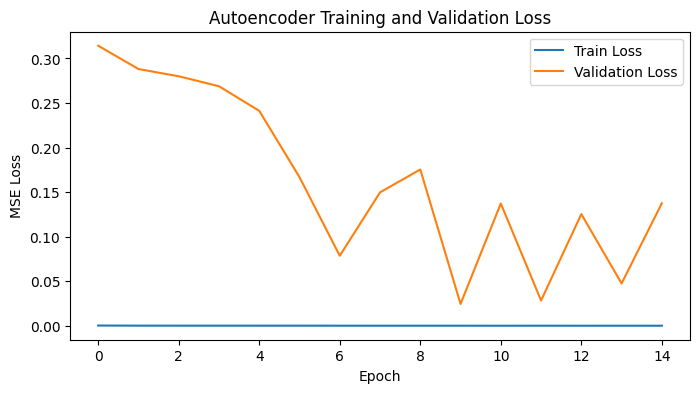

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training and Validation Loss")
plt.legend()
plt.show()


In [43]:
import torch.nn.functional as F

recon_errors = []

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        recon = model(x_batch)
        # MSE per sample
        errors = F.mse_loss(recon, x_batch, reduction='none')
        errors = errors.mean(dim=1)  # average over features
        recon_errors.extend(errors.cpu().numpy())

recon_errors = np.array(recon_errors)
print("Reconstruction errors shape:", recon_errors.shape)


Reconstruction errors shape: (575061,)


In [44]:
# Use training set reconstruction errors to set threshold
train_errors = []

with torch.no_grad():
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        recon = model(x_batch)
        errors = F.mse_loss(recon, x_batch, reduction='none')
        errors = errors.mean(dim=1)
        train_errors.extend(errors.cpu().numpy())

train_errors = np.array(train_errors)
threshold = np.mean(train_errors) + 3*np.std(train_errors)
print("Anomaly detection threshold:", threshold)


Anomaly detection threshold: 5.8133087


In [45]:
y_pred = (recon_errors > threshold).astype(int)

# Compare with true labels
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal','Anomaly']))


Confusion Matrix:
[[558201     22]
 [  8324   8514]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99    558223
     Anomaly       1.00      0.51      0.67     16838

    accuracy                           0.99    575061
   macro avg       0.99      0.75      0.83    575061
weighted avg       0.99      0.99      0.98    575061



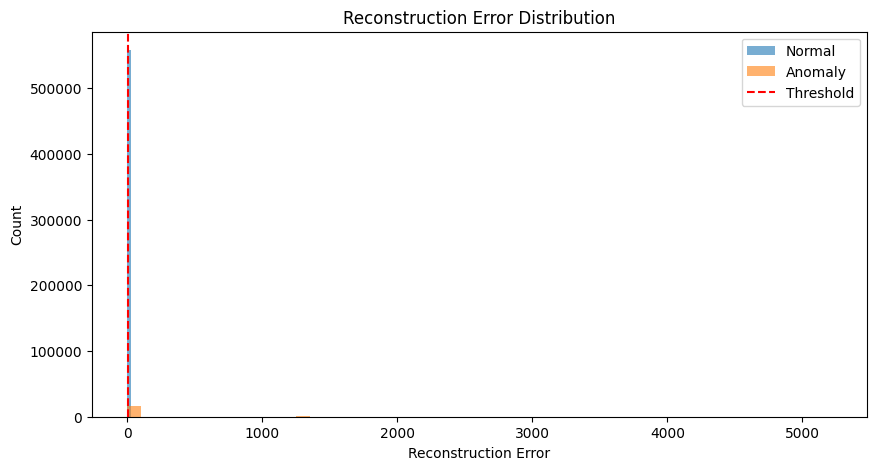

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(recon_errors[y_test==0], bins=50, alpha=0.6, label='Normal')
plt.hist(recon_errors[y_test==1], bins=50, alpha=0.6, label='Anomaly')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.title("Reconstruction Error Distribution")
plt.legend()
plt.show()


In [48]:
# Get top 10 anomalies by reconstruction error
top_idx = np.argsort(-recon_errors)[:10]
for idx in top_idx:
    print(f"BlockId: {df['BlockId'].iloc[idx]}, Reconstruction Error: {recon_errors[idx]:.4f}, Label: {y_test[idx]}")


BlockId: blk_-1819104424294912767, Reconstruction Error: 5216.7285, Label: 1
BlockId: blk_-8266956839135631201, Reconstruction Error: 3934.1016, Label: 1
BlockId: blk_-3174232733041654340, Reconstruction Error: 2409.2954, Label: 1
BlockId: blk_8446397119190875084, Reconstruction Error: 2335.0813, Label: 1
BlockId: blk_5306532226836293852, Reconstruction Error: 1771.2225, Label: 1
BlockId: blk_8704470484017517454, Reconstruction Error: 1771.2225, Label: 1
BlockId: blk_-3729108565813298751, Reconstruction Error: 1768.3331, Label: 1
BlockId: blk_2580538676052527085, Reconstruction Error: 1764.2286, Label: 1
BlockId: blk_-7299274901927785583, Reconstruction Error: 1764.2286, Label: 1
BlockId: blk_4495235710681479625, Reconstruction Error: 1761.6716, Label: 1
